## Optional analysis of the labels we are left with after the initial filtering pass
Labels are generated in the candidate_label_creation notebook and then filtered in the candidate_filter notebook.

### Pre-requisite steps to run this notebook
1. You need to run the candidate_label_creation and candidate_filter notebooks before this notebook.

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utility import run_command

### Parameters
**Required**  
*work_dir*: path to work_dir that was specified in candidate_label_creation and candidate_filter notebooks. This should contain a folder called label_creation and a folder called candidate_filter.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.  
*label_file*: file path for the file that contains wikidata labels.

In [52]:
# **REQUIRED**
work_dir = "../../Q154/profiler_work"
store_dir = "../../Q154"
label_file = "../../Q154/data/labels.en.tsv.gz"

### Process params / set up variables

In [53]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
label_file = os.path.abspath(label_file)

label_creation_dir = "{}/label_creation".format(work_dir)
filter_dir = "{}/candidate_filter".format(work_dir)
    
# Create output directory
output_dir = "{}/analyze_filtered_labels".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = label_creation_dir
os.environ['FILTERED_LABELS'] = filter_dir
os.environ['LABEL_FILE'] = label_file
os.environ["OUT"] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## pre-processing...
To make labels easier to look through, we'll:
1. Add human readable labels* for Wikidata nodes and properties.
2. Add a label-kind column to our labels so that we can key on this after we combine the labels into a single table.
3. Add a column for number of entities of type = label's type
4. Standardize/disambiguate column headers across label kinds so they can be combined into a single table.

*sorry for the ambiguous wording here - "labels" in this sentence refers to a different thing than the labels we are analyzing in this notebook

**AVLs**

In [65]:
if not os.path.isfile("{}/candidate_labels_avl_string_filtered.tsv".format(filter_dir)):
    string_file_exists = False
    print("No string labels file found, skipping this step.")
else:
    string_file_exists = True
    # perform query
    command = "$kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_string_filtered.tsv \
               -i LABEL_FILE -o $OUT/filtered_avl_string_analysis.tsv \
               --graph-cache $STORE \
               --match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `LABEL_FILE`: (type)-[]->(type_lab)' \
               --return 'distinct \"AVL\" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, \"\" as val1_lab, \"\" as val1_ub, \"\" as type2, \"\" as type2_lab, \"\" as prop2, \"\" as prop2_lab, \"\" as val2, \"\" as val2_ub, \"\" as si_units, \"\" as wd_units' \
               --where 'type_lab.kgtk_lqstring_lang_suffix = \"en\"'"
    run_command(command, {"LABEL_FILE" : label_file})

No string labels file found, skipping this step.


In [66]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [67]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RELs**

In [68]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rel_item_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rel_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab), `'"$LABEL_FILE"'`: (val)-[]->(val_lab)' \
--return 'distinct "REL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, val_lab as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND val_lab.kgtk_lqstring_lang_suffix = "en"'

**AILs**

In [69]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, upper_bound:ub, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [70]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, upper_bound:ub, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RAVLs**

In [71]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ravl_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ravl_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, val:val2, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, val2 as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


**RAILs**

In [72]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rail_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rail_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, lb as val2, ub as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


Defining filename variables and the order of columns in our analysis files since we'll need thess in a couple places.

In [73]:
if string_file_exists:
    avl_string_file = "{}/filtered_avl_string_analysis.tsv".format(output_dir)
avl_quantity_file = "{}/filtered_avl_quantity_analysis.tsv".format(output_dir)
avl_year_file = "{}/filtered_avl_time.year_analysis.tsv".format(output_dir)
rel_file = "{}/filtered_rel_analysis.tsv".format(output_dir)
ail_quantity_file = "{}/filtered_ail_quantity_analysis.tsv".format(output_dir)
ail_year_file = "{}/filtered_ail_time.year_analysis.tsv".format(output_dir)
ravl_file = "{}/filtered_ravl_analysis.tsv".format(output_dir)
rail_file = "{}/filtered_rail_analysis.tsv".format(output_dir)
all_file = "{}/filtered_all_analysis.tsv".format(output_dir)

all_cols = ["label_kind","positives", "num_type1_ents", "support", "type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "val1_ub", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units"]
avl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "si_units", "wd_units","positives", "num_type1_ents", "support"]
rel_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "positives", "num_type1_ents", "support"]
ail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
ravl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
rail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]


Creating a combined analysis files

In [74]:
df = pd.read_csv(avl_quantity_file, delimiter = '\t')
if string_file_exists:
    df = df.append(pd.read_csv(avl_string_file, delimiter = '\t'))
df = df.append(pd.read_csv(avl_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(rel_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_quantity_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(ravl_file, delimiter = '\t'))
df = df.append(pd.read_csv(rail_file, delimiter = '\t'))

df[all_cols].to_csv(path_or_buf = all_file, sep = '\t', index = False)

Helper function for viewing label support / positives distribution

In [75]:
"""
Given a file containing labels, optionally filter by the labels' type1,
plot label support and label count histograms, and print out some examples
of labels at various bins of the histograms.
"""
def plot_label_supports_and_positives(filename, cols_to_print_in_order, type1 = None,
                                      log_scale_supports = False, log_scale_positives = False):
    df = pd.read_csv(filename, delimiter = '\t')
    # We get NA when reading blank cells.
    # Blank cells are expected, so we'll change them back to avoid confusion when displaying
    df.fillna("", inplace = True) 
    
    if type1 is not None:
        df = df.loc[df.loc[:,"type1"] == type1]
        
    if df.empty:
        print("There are no labels in the given file with type = {}".format(type1))
        return
        
    supports = df.loc[:,"support"]
    positives = df.loc[:,"positives"]
    
    fig, (ax_sup, ax_pos) = plt.subplots(1, 2, figsize = (14,5))
    
    ax_sup.hist(supports, bins = np.arange(0,1.01,.02))
    ax_sup.set_xlabel("Support (# positives for this label / # entities with this label's type)")
    ax_sup.set_ylabel("# Labels")
    ax_sup.set_title("Distribution of Support for Labels")
    if log_scale_supports:
        ax_sup.set_yscale("log")
    
    ax_pos.hist(positives, bins = range(0,max(positives)+2,1), align = "left")
    ax_pos.set_xlabel("# Positives")
    ax_pos.set_ylabel("# Labels")
    ax_pos.set_title("Distribution of Number of Positives for Labels")
    if log_scale_positives:
        ax_pos.set_yscale("log")
 
    plt.tight_layout()
    plt.show()
    
    # Show some examples of labels in various bins of the histograms
    
    print("Examples of labels at several values of support...")
    unique_supports_sorted = sorted(set(supports))
    examples_df = pd.DataFrame()
    num_to_show = 5
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        sup = unique_supports_sorted[int((i/4) * (len(unique_supports_sorted)-1))]
        if sup not in num_shown_from_bin:
            num_shown_from_bin[sup] = 0
        ix_to_choose = num_shown_from_bin[sup]
        examples_in_bin = df.loc[df.loc[:,"support"] == sup]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[sup] += 1
    display(examples_df[cols_to_print_in_order])
        
    print("\nExamples of labels at several values of positives...")
    unique_positives_sorted = sorted(set(positives))
    examples_df = pd.DataFrame()
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        pos = unique_positives_sorted[int((i/4) * (len(unique_positives_sorted)-1))]
        if pos not in num_shown_from_bin:
            num_shown_from_bin[pos] = 0
        ix_to_choose = num_shown_from_bin[pos]
        examples_in_bin = df.loc[df.loc[:,"positives"] == pos]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[pos] += 1
    display(examples_df[cols_to_print_in_order])

### AVL - string

In [76]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, log_scale_positives = True)

No string labels file found, skipping this step.


### AVL - year

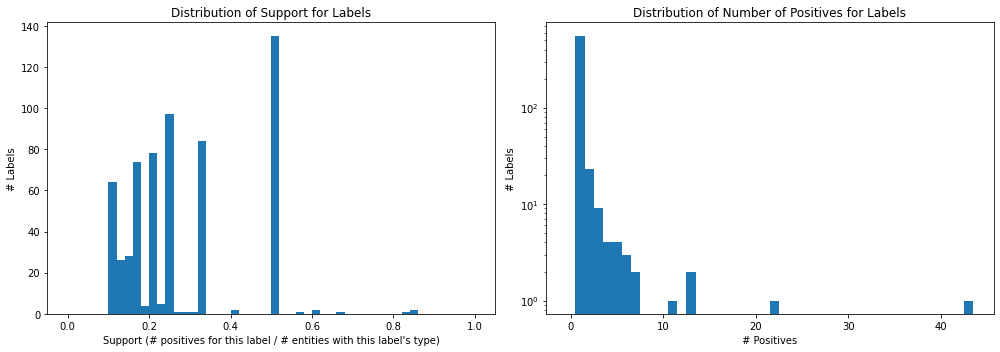

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q123480,'landlocked country'@en,P571,'inception'@en,1918.0,,,2.0,20.0,0.100000
65,Q3502482,'cultural region'@en,P571,'inception'@en,1689.0,,,1.0,8.0,0.125000
195,Q25866325,'craft beer'@en,P571,'inception'@en,1996.0,,,11.0,58.0,0.189655
377,Q21191270,'television series episode'@en,P577,'publication date'@en,1988.0,,,2.0,7.0,0.285714
605,Q21191270,'television series episode'@en,P1191,'date of first performance'@en,1968.0,,,6.0,7.0,0.857143



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
3,Q167296,'cider'@en,P571,'inception'@en,1962.0,,,1.0,10.0,0.100000
12,Q50337,'prefecture of Japan'@en,P571,'inception'@en,1868.0,,,3.0,28.0,0.107143
8,Q25866325,'craft beer'@en,P571,'inception'@en,1995.0,,,6.0,58.0,0.103448
195,Q25866325,'craft beer'@en,P571,'inception'@en,1996.0,,,11.0,58.0,0.189655
604,Q6465,'department of France'@en,P571,'inception'@en,1790.0,,,43.0,52.0,0.826923


In [77]:
plot_label_supports_and_positives(avl_year_file, avl_cols, log_scale_positives = True)

### AVL - quantity

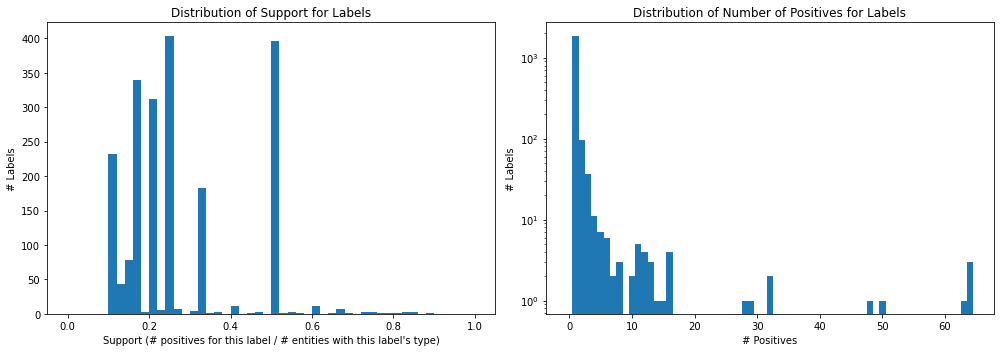

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q123480,'landlocked country'@en,P1198,'unemployment rate'@en,4.0,,Q11229,2.0,20.0,0.100000
353,Q5119,'capital'@en,P2044,'elevation above sea level'@en,6.0,,Q11573,2.0,12.0,0.166667
1427,Q687737,'Bock'@en,P2665,'alcohol by volume'@en,6.5,,Q2080811,3.0,9.0,0.333333
2034,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18.0,,Q24564698,63.0,104.0,0.605769
2060,Q63791824,'countries bordering the Baltic Sea'@en,P3000,'marriageable age'@en,18.0,,Q24564698,8.0,9.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
23,Q167296,'cider'@en,P2665,'alcohol by volume'@en,4.7,,Q2080811,1.0,10.0,0.100000
1420,Q7270,'republic'@en,P2884,'mains voltage'@en,220.0,,Q25250,6.0,22.0,0.272727
231,Q6256,'country'@en,P3001,'retirement age'@en,65.0,,Q24564698,12.0,105.0,0.114286
1419,Q3624078,'sovereign state'@en,P3270,'compulsory education (minimum age)'@en,6.0,,Q577,28.0,104.0,0.269231
2035,Q6256,'country'@en,P2997,'age of majority'@en,18.0,,Q24564698,64.0,105.0,0.609524


In [78]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, log_scale_positives = True)

### AIL - year

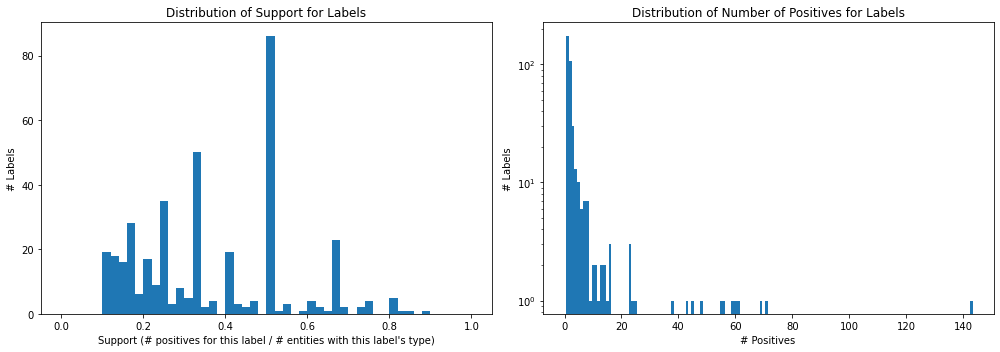

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q515,'city'@en,P571,'inception'@en,-3657.5,423.5,,,4.0,40.0,0.100000
53,Q2140699,'wine-producing region'@en,P571,'inception'@en,1969.5,1987,,,11.0,67.0,0.164179
158,Q282,'wine'@en,P571,'inception'@en,1957.5,2000.5,,,59.0,205.0,0.287805
333,Q1565828,'appellation d\\\\'origine contrôlée'@en,P571,'inception'@en,,1963,,,61.0,118.0,0.516949
384,Q10373548,'whisky distillery'@en,P571,'inception'@en,,,,,8.0,9.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
9,Q3331189,"'version, edition, or translation'@en",P577,'publication date'@en,,1855.5,,,1.0,9.0,0.111111
31,Q5,'human'@en,P569,'date of birth'@en,1360,1566.5,,,8.0,60.0,0.133333
248,Q3139487,'Denominación de Origen'@en,P571,'inception'@en,,,,,16.0,32.0,0.500000
377,Q5,'human'@en,P569,'date of birth'@en,1682,,,,48.0,60.0,0.800000
370,Q131734,'brewery'@en,P571,'inception'@en,1809.5,,,,143.0,205.0,0.697561


In [79]:
plot_label_supports_and_positives(ail_year_file, ail_cols, log_scale_positives = True)

### AIL - quantity

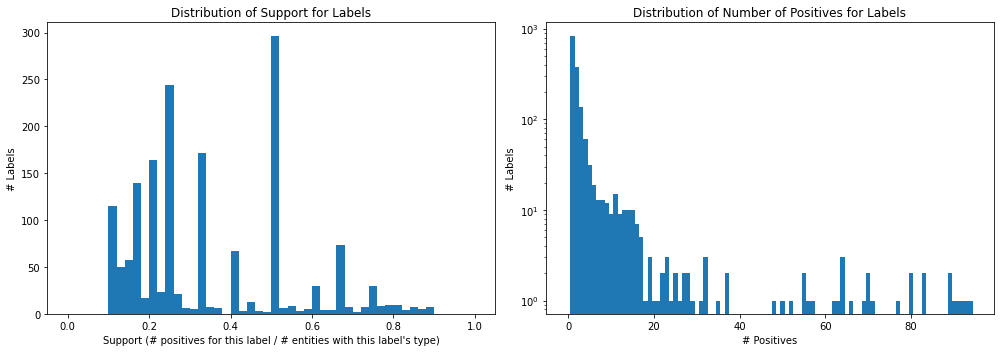

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.45,7.000000e+00,,Q2080811,14.0,140.0,0.100000
533,Q6881511,'enterprise'@en,P1128,'employees'@en,,5.042450e+04,,,10.0,48.0,0.208333
1113,Q6256,'country'@en,P1082,'population'@en,,7.014162e+07,,,52.0,105.0,0.495238
1544,Q2074737,'municipality of Spain'@en,P2046,'area'@en,,3.623250e+02,,Q712226,23.0,33.0,0.696970
1637,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.050000e+00,,Q11229,94.0,105.0,0.895238



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
46,Q167296,'cider'@en,P2665,'alcohol by volume'@en,,,,Q2080811,1.0,10.0,0.100000
0,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.45,7,,Q2080811,14.0,140.0,0.100000
812,Q6256,'country'@en,P3270,'compulsory education (minimum age)'@en,5.5,6.5,,Q24564698,28.0,105.0,0.266667
1432,Q6256,'country'@en,P2997,'age of majority'@en,17.5,18.5,,Q24564698,63.0,105.0,0.600000
1637,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229,94.0,105.0,0.895238


In [80]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, log_scale_positives = True)

### RELs

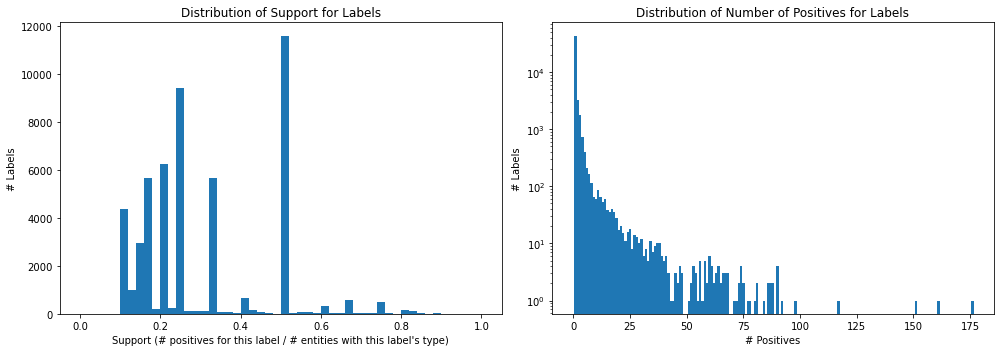

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
554,Q484170,'commune of France'@en,P131,'located in the administrative territorial ent...,Q12526,'Gironde'@en,7.0,70.0,0.100000
535,Q167270,'trademark'@en,P31,'instance of'@en,Q44,'beer'@en,15.0,86.0,0.174419
453,Q3624078,'sovereign state'@en,P421,'located in time zone'@en,Q6655,'UTC+01:00'@en,32.0,104.0,0.307692
1507,Q123480,'landlocked country'@en,P463,'member of'@en,Q8908,'Council of Europe'@en,11.0,20.0,0.550000
1531,Q123480,'landlocked country'@en,P463,'member of'@en,Q1043527,'Multilateral Investment Guarantee Agency'@en,18.0,20.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
3144,Q167296,'cider'@en,P127,'owned by'@en,Q113215,'Carlsberg Group'@en,1.0,10.0,0.100000
156,Q6256,'country'@en,P2853,'electrical plug type'@en,Q24288454,'NEMA 1-15'@en,22.0,105.0,0.209524
239,Q6256,'country'@en,P530,'diplomatic relation'@en,Q851,'Saudi Arabia'@en,43.0,105.0,0.409524
19,Q15075508,'beer brand'@en,P495,'country of origin'@en,Q31,'Belgium'@en,66.0,201.0,0.328358
11,Q131734,'brewery'@en,P452,'industry'@en,Q869095,'brewing'@en,176.0,205.0,0.858537


In [81]:
plot_label_supports_and_positives(rel_file, rel_cols, log_scale_positives = True)

### RAVLs

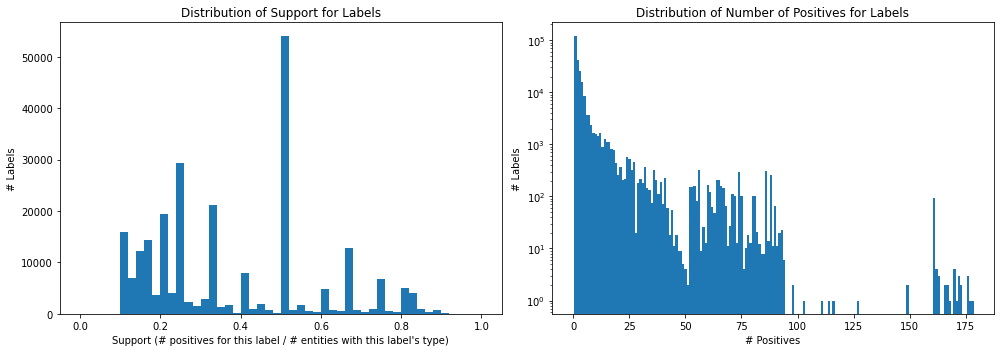

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
0,Q44,'beer'@en,P17,'country'@en,Q20181813,'colonial power'@en,P3270,'compulsory education (minimum age)'@en,6.0,,Q24564698,14.0,140.0,0.100000
52602,Q55977691,'Wikidata property for authority control for a...,P17,'country'@en,Q3624078,'sovereign state'@en,P2855,'VAT-rate'@en,20.0,,Q11229,9.0,48.0,0.187500
133826,Q19595382,'Wikidata property for authority control for p...,P17,'country'@en,Q6256,'country'@en,P2884,'mains voltage'@en,230.0,,Q25250,72.0,214.0,0.336449
205277,Q96776953,'Wikidata property for authority control (libr...,P17,'country'@en,Q3624078,'sovereign state'@en,P2884,'mains voltage'@en,230.0,,Q25250,21.0,37.0,0.567568
245717,Q123480,'landlocked country'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18.0,,Q24564698,18.0,20.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
3889,Q167296,'cider'@en,P127,'owned by'@en,Q131734,'brewery'@en,P571,'inception'@en,1847.0,,,1.0,10.0,0.100000
53109,Q4830453,'business'@en,P17,'country'@en,Q20181813,'colonial power'@en,P2997,'age of majority'@en,18.0,,Q24564698,29.0,148.0,0.195946
108208,Q131734,'brewery'@en,P17,'country'@en,Q20181813,'colonial power'@en,P3000,'marriageable age'@en,18.0,,Q24564698,57.0,205.0,0.278049
145573,Q15075508,'beer brand'@en,P495,'country of origin'@en,Q6256,'country'@en,P2884,'mains voltage'@en,230.0,,Q25250,85.0,201.0,0.422886
244924,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18.0,,Q24564698,178.0,205.0,0.868293


In [82]:
plot_label_supports_and_positives(ravl_file, ravl_cols, log_scale_positives = True)

### RAILs

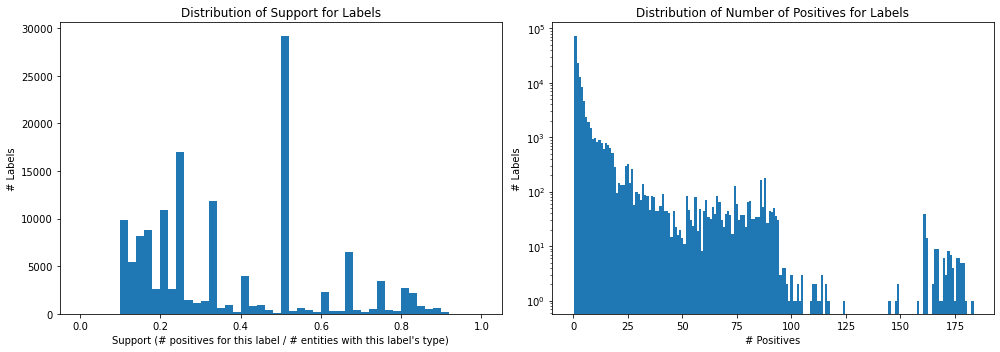

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q44,'beer'@en,P17,'country'@en,Q20181813,'colonial power'@en,P2132,'nominal GDP per capita'@en,29887.5,50342.5,,Q4917,14.0,140.0,0.100000
44888,Q747074,'comune of Italy'@en,P47,'shares border with'@en,Q747074,'comune of Italy'@en,P2046,'area'@en,114.295,150.905,,Q712226,8.0,39.0,0.205128
81579,Q55977691,'Wikidata property for authority control for a...,P17,'country'@en,Q3624078,'sovereign state'@en,P2573,'number of out-of-school children'@en,,817670,,,17.0,48.0,0.354167
118931,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q859563,'secular state'@en,P1198,'unemployment rate'@en,6,,,Q11229,58.0,104.0,0.557692
140834,Q515,'city'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2299,'PPP GDP per capita'@en,,57625,,Q550207,36.0,40.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
1733,Q167296,'cider'@en,P127,'owned by'@en,Q131734,'brewery'@en,P571,'inception'@en,1809.5,,,,1.0,10.0,0.100000
31781,Q131734,'brewery'@en,P17,'country'@en,Q6256,'country'@en,P1125,'Gini coefficient'@en,,,,,35.0,205.0,0.170732
81101,Q15075508,'beer brand'@en,P17,'country'@en,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229,69.0,201.0,0.343284
117955,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2884,'mains voltage'@en,225,235,,Q25250,103.0,205.0,0.502439
140566,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P571,'inception'@en,1642,,,,183.0,205.0,0.892683


In [83]:
plot_label_supports_and_positives(rail_file, rail_cols, log_scale_positives = True)

### All

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


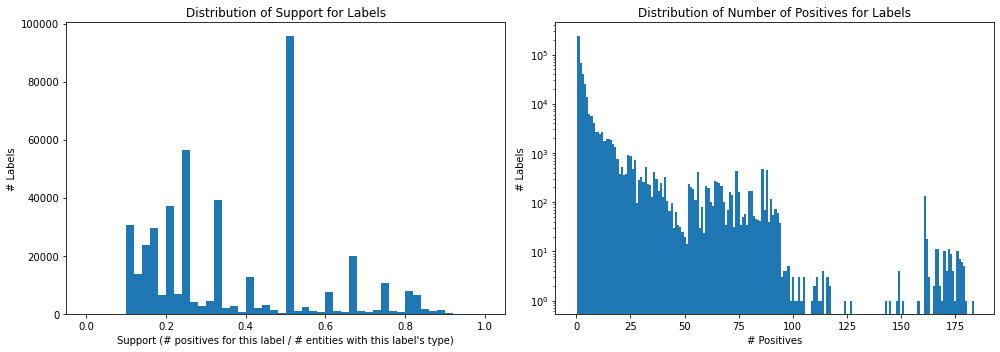

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
0,AVL,2.0,20.0,0.100000,Q123480,'landlocked country'@en,P1198,'unemployment rate'@en,4.0,,,,,,,,,,Q11229
346431,RAIL,42.0,205.0,0.204878,Q131734,'brewery'@en,P131,'located in the administrative territorial ent...,,,,Q50337,'prefecture of Japan'@en,P2046,'area'@en,,10385,,Q712226
3138,REL,37.0,104.0,0.355769,Q3624078,'sovereign state'@en,P1343,'described by source'@en,Q4114391,'Sytin Military Encyclopedia'@en,,,,,,,,,
260864,RAVL,59.0,104.0,0.567308,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,2.9,,,Q11229
4199,REL,18.0,20.0,0.900000,Q123480,'landlocked country'@en,P463,'member of'@en,Q1043527,'Multilateral Investment Guarantee Agency'@en,,,,,,,,,



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
23,AVL,1.0,10.0,0.100000,Q167296,'cider'@en,P2665,'alcohol by volume'@en,4.7,,,,,,,,,,Q2080811
2885,REL,36.0,105.0,0.342857,Q6256,'country'@en,P463,'member of'@en,Q41550,'Organisation for Economic Cooperation and Dev...,,,,,,,,,
3185,REL,71.0,104.0,0.682692,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q38,'Italy'@en,,,,,,,,,
419520,RAIL,109.0,214.0,0.509346,Q19595382,'Wikidata property for authority control for p...,P17,'country'@en,,,,Q6256,'country'@en,P571,'inception'@en,1640,,,
442110,RAIL,183.0,205.0,0.892683,Q131734,'brewery'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P571,'inception'@en,1642,,,


In [84]:
plot_label_supports_and_positives(all_file, all_cols, log_scale_positives = True)

## Let's look at a subset of these labels since there are a lot of them here. 
Filter on type1 = Q44 (beer)

### Optional - create a file we can view in Excel
First let's create a smaller "all-labels" file just for type1=Q44 since this will be small enough that we can view the labels in Excel.

In [25]:
df = pd.read_csv(all_file, delimiter = '\t')
df = df.loc[df.loc[:,"type1"] == "Q44"]
type1_is_q44_all_file = "{}/filtered_all_analysis_type1_is_q44.tsv".format(output_dir)
df[all_cols].to_csv(path_or_buf = type1_is_q44_all_file, sep = '\t', index = False)

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


And again here are histograms of the label supports and positives...

In [95]:
type1 = "Q282" # can change this to another type and then re-run the below cells.

### AVL - string

In [96]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, type1 = type1)

No string labels file found, skipping this step.


### AVL - year

In [97]:
plot_label_supports_and_positives(avl_year_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q282


### AVL - quantity

In [98]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q282


### AIL - year

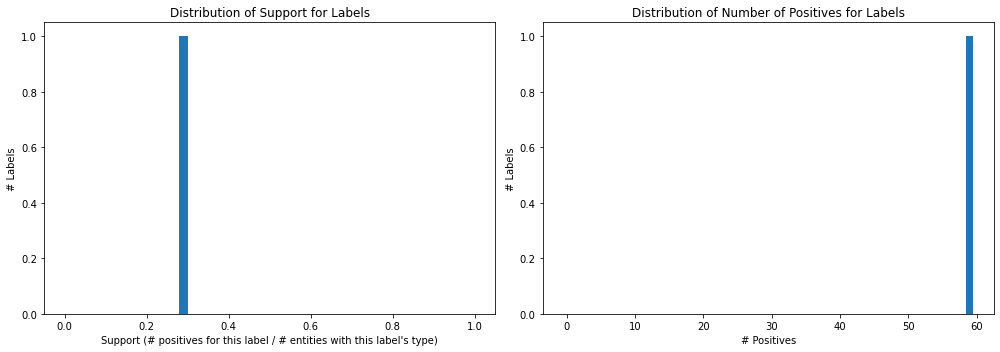

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
158,Q282,'wine'@en,P571,'inception'@en,1957.5,2000.5,,,59.0,205.0,0.287805



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
158,Q282,'wine'@en,P571,'inception'@en,1957.5,2000.5,,,59.0,205.0,0.287805


In [99]:
plot_label_supports_and_positives(ail_year_file, ail_cols, type1 = type1)

### AIL - quantity

In [100]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, type1 = type1)

There are no labels in the given file with type = Q282


### RELs

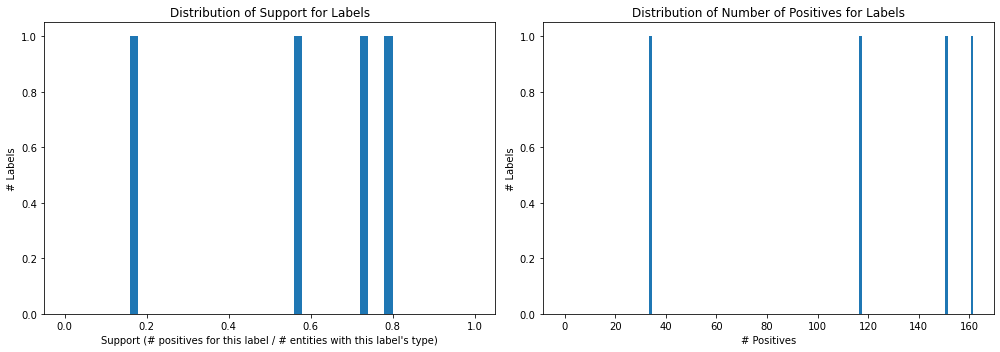

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
12,Q282,'wine'@en,P1389,'product certification'@en,Q2305591,'Denominazione di Origine Controllata e Garant...,34.0,205.0,0.165854
13,Q282,'wine'@en,P1389,'product certification'@en,Q654824,'Denominazione di origine controllata'@en,117.0,205.0,0.570732
14,Q282,'wine'@en,P279,'subclass of'@en,Q1125341,'Italian wine'@en,151.0,205.0,0.736585
15,Q282,'wine'@en,P17,'country'@en,Q38,'Italy'@en,161.0,205.0,0.785366



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
12,Q282,'wine'@en,P1389,'product certification'@en,Q2305591,'Denominazione di Origine Controllata e Garant...,34.0,205.0,0.165854
13,Q282,'wine'@en,P1389,'product certification'@en,Q654824,'Denominazione di origine controllata'@en,117.0,205.0,0.570732
14,Q282,'wine'@en,P279,'subclass of'@en,Q1125341,'Italian wine'@en,151.0,205.0,0.736585
15,Q282,'wine'@en,P17,'country'@en,Q38,'Italy'@en,161.0,205.0,0.785366


In [101]:
plot_label_supports_and_positives(rel_file, rel_cols, type1 = type1)

### RAVLs

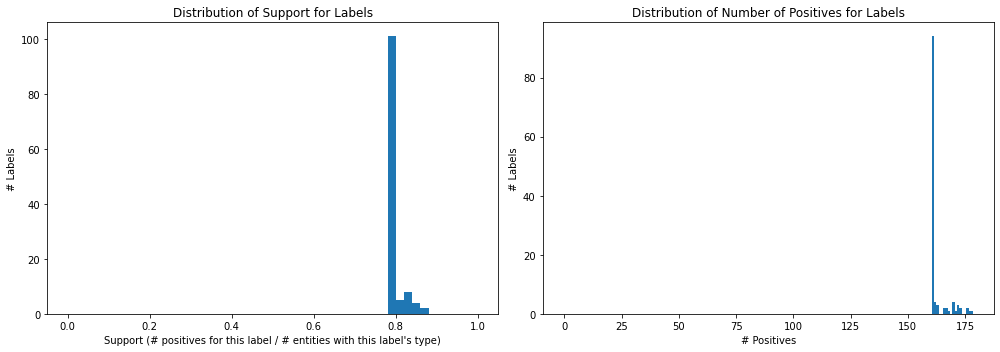

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
234238,Q282,'wine'@en,P17,'country'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.88,,,161.0,205.0,0.785366
239279,Q282,'wine'@en,P17,'country'@en,Q7270,'republic'@en,P3271,'compulsory education (maximum age)'@en,16.00,,Q24564698,166.0,205.0,0.809756
239768,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P3271,'compulsory education (maximum age)'@en,16.00,,Q24564698,170.0,205.0,0.829268
243881,Q282,'wine'@en,P17,'country'@en,Q51576574,'Mediterranean country'@en,P2997,'age of majority'@en,18.00,,Q24564698,173.0,205.0,0.843902
244924,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18.00,,Q24564698,178.0,205.0,0.868293



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
234238,Q282,'wine'@en,P17,'country'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.88,,,161.0,205.0,0.785366
239279,Q282,'wine'@en,P17,'country'@en,Q7270,'republic'@en,P3271,'compulsory education (maximum age)'@en,16.00,,Q24564698,166.0,205.0,0.809756
239768,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P3271,'compulsory education (maximum age)'@en,16.00,,Q24564698,170.0,205.0,0.829268
243881,Q282,'wine'@en,P17,'country'@en,Q51576574,'Mediterranean country'@en,P2997,'age of majority'@en,18.00,,Q24564698,173.0,205.0,0.843902
244924,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18.00,,Q24564698,178.0,205.0,0.868293


In [102]:
plot_label_supports_and_positives(ravl_file, ravl_cols, type1 = type1)

### RAILs

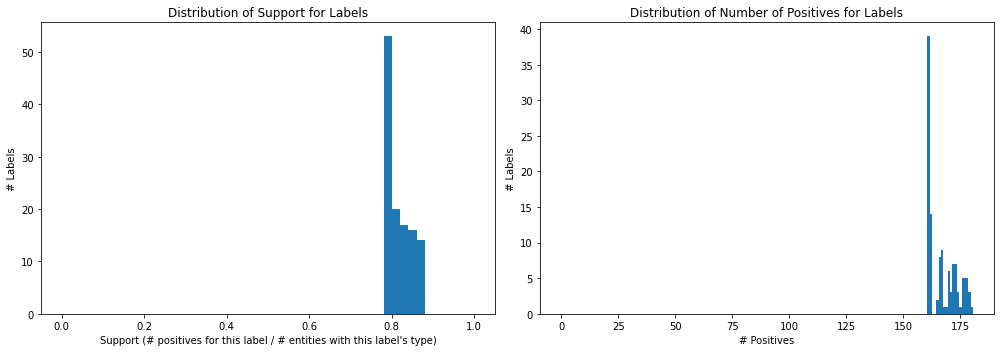

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
133797,Q282,'wine'@en,P17,'country'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,7.255000e-01,,,,161.0,205.0,0.785366
136554,Q282,'wine'@en,P17,'country'@en,Q7270,'republic'@en,P1081,'Human Development Index'@en,6.700000e-01,,,,167.0,205.0,0.814634
138914,Q282,'wine'@en,P17,'country'@en,Q51576574,'Mediterranean country'@en,P2131,'nominal GDP'@en,2.931098e+11,,,Q4917,171.0,205.0,0.834146
139604,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1198,'unemployment rate'@en,1.450000e+00,15,,Q11229,175.0,205.0,0.853659
140273,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.800000e+00,9.05,,Q11229,180.0,205.0,0.878049



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
133797,Q282,'wine'@en,P17,'country'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,7.255000e-01,,,,161.0,205.0,0.785366
136554,Q282,'wine'@en,P17,'country'@en,Q7270,'republic'@en,P1081,'Human Development Index'@en,6.700000e-01,,,,167.0,205.0,0.814634
138914,Q282,'wine'@en,P17,'country'@en,Q51576574,'Mediterranean country'@en,P2131,'nominal GDP'@en,2.931098e+11,,,Q4917,171.0,205.0,0.834146
139604,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1198,'unemployment rate'@en,1.450000e+00,15,,Q11229,175.0,205.0,0.853659
140273,Q282,'wine'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.800000e+00,9.05,,Q11229,180.0,205.0,0.878049


In [103]:
plot_label_supports_and_positives(rail_file, rail_cols, type1 = type1)

### All

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


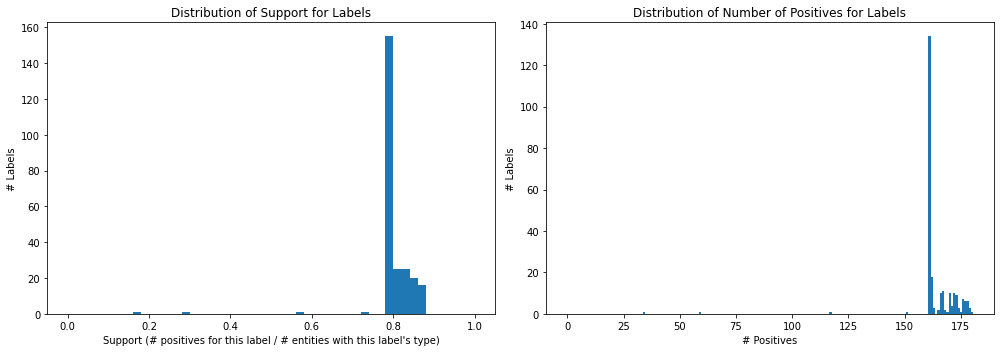

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
2680,REL,34.0,205.0,0.165854,Q282,'wine'@en,P1389,'product certification'@en,Q2305591,'Denominazione di Origine Controllata e Garant...,,,,,,,,,
290102,RAVL,162.0,205.0,0.790244,Q282,'wine'@en,P17,'country'@en,,,,Q619610,'social state'@en,P2884,'mains voltage'@en,230,,,Q25250
438347,RAIL,169.0,205.0,0.824390,Q282,'wine'@en,P17,'country'@en,,,,Q51576574,'Mediterranean country'@en,P1198,'unemployment rate'@en,7.55,14.5,,Q11229
440903,RAIL,174.0,205.0,0.848780,Q282,'wine'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2573,'number of out-of-school children'@en,,817670,,
441817,RAIL,180.0,205.0,0.878049,Q282,'wine'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
2680,REL,34.0,205.0,0.165854,Q282,'wine'@en,P1389,'product certification'@en,Q2305591,'Denominazione di Origine Controllata e Garant...,,,,,,,,,
290102,RAVL,162.0,205.0,0.790244,Q282,'wine'@en,P17,'country'@en,,,,Q619610,'social state'@en,P2884,'mains voltage'@en,230,,,Q25250
438347,RAIL,169.0,205.0,0.824390,Q282,'wine'@en,P17,'country'@en,,,,Q51576574,'Mediterranean country'@en,P1198,'unemployment rate'@en,7.55,14.5,,Q11229
440903,RAIL,174.0,205.0,0.848780,Q282,'wine'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2573,'number of out-of-school children'@en,,817670,,
441817,RAIL,180.0,205.0,0.878049,Q282,'wine'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229


In [104]:
plot_label_supports_and_positives(all_file, all_cols, type1 = type1)